# Sistema básico de transmissão 4-QAM

In [5]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from optic.dsp.core import pulseShape, signal_power, pnorm
from optic.comm.modulation import GrayMapping

outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

In [7]:
"""
Define uma classe que herda Structure para representação de números complexos.
"""
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]
    
typeComplex = np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS") # "matrizes np.complex64"

def tuple2numpy(arr):
    """ 
    Converte uma tuple de valores reais e imaginários em um array
    numpy, (real, imag) --> np.array

    Args:
        arr (tuple): tuple contendo valores reais e imaginários
    
    Returns:
        np.array: array numpy de tipo complexo.
    """
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

def c2py(arr, shape):
    """
    Converta matrizes de C para Python.

    Args:
        arr (class '__main__.LP_Complex'): matriz de conversão para numpy
        shape (int): comprimento do array 1D
    
    Returns:
        arr (np.array): matriz do tipo numpy unidimensional.
    """
    return tuple2numpy(np.ctypeslib.as_array(arr, shape=(shape,)))

## Defina as funções do DSP

In [17]:
# decimação
dsp.downsample.restype  = POINTER(Complex)
dsp.downsample.argtypes = [typeComplex, c_int, c_int]

# filtro casado
dsp.matchedFilter.restype  = POINTER(Complex)
dsp.matchedFilter.argtypes = [typeComplex, typeComplex, c_int, c_int]

# filtro FIR
dsp.firFilter.restype  = POINTER(Complex)
dsp.firFilter.argtypes = [typeComplex, typeComplex, c_int, c_int]

# mainUP
dsp.mainUpSymbols.restype  = POINTER(Complex)
dsp.mainUpSymbols.argtypes = [c_int, c_int]

# define o detector ML 
dsp.MLdetector.restype = POINTER(Complex)
dsp.MLdetector.argtypes = [typeComplex, typeComplex, c_int, c_int]

# normalização
dsp.pnorm.restype  = POINTER(Complex)            
dsp.pnorm.argtypes = [typeComplex, c_int]

# ruído gaussiano
dsp.noise.restype = POINTER(Complex)
dsp.noise.argtypes = [c_int, c_float, c_float]

## Gere sinais 4-QAM

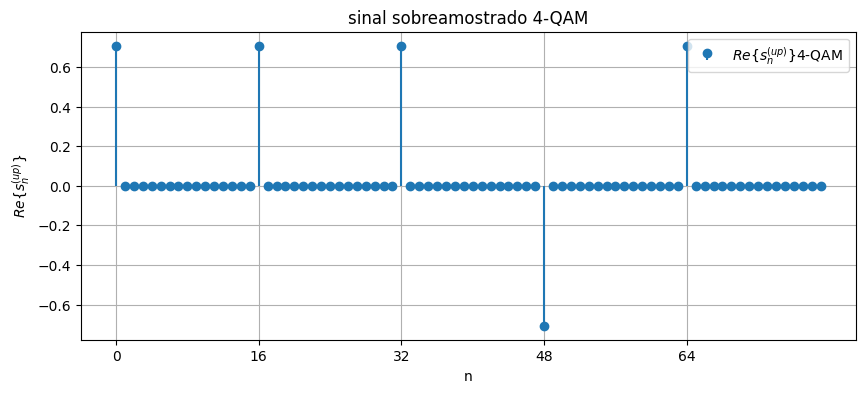

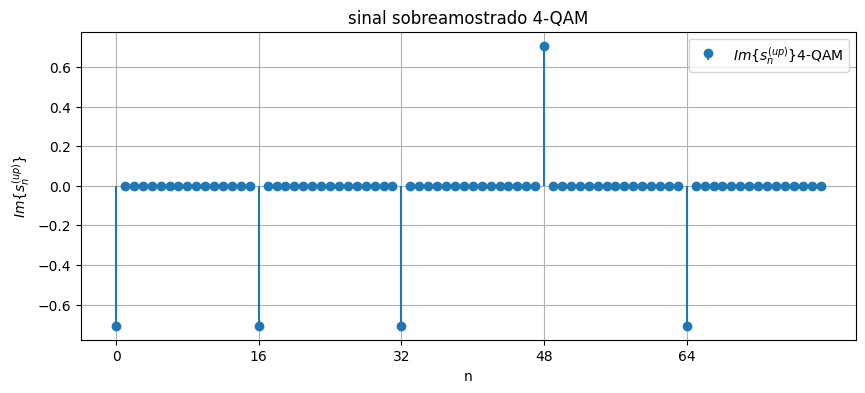

In [19]:
# Parâmetros da simulação:

M = 4              # Ordem de modulação QAM
SpS = 16           # Amostras por símbolo
Rs = 100e6         # Taxa de símbolos [símbolo/s]
Ts = 1/Rs          # Período de símbolo em segundos
Fa = 1/(Ts/SpS)    # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa          # Período de amostragem
nBits = 1e3        # Comprimento do bitstream
pulseType = "rc"   # Pulso RC típico

constSymb = GrayMapping(M, 'qam') 
constSymb = np.array(pnorm(constSymb), dtype="complex64")

Nbits = int(nBits * np.log2(M))

symbolsUp = dsp.mainUpSymbols(Nbits, SpS)
symbolsUp = c2py(symbolsUp, int((Nbits/2)*SpS))

plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

plt.figure(2, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].imag, basefmt=" ", label ='$Im\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Im\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

## Formatação de Pulso

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


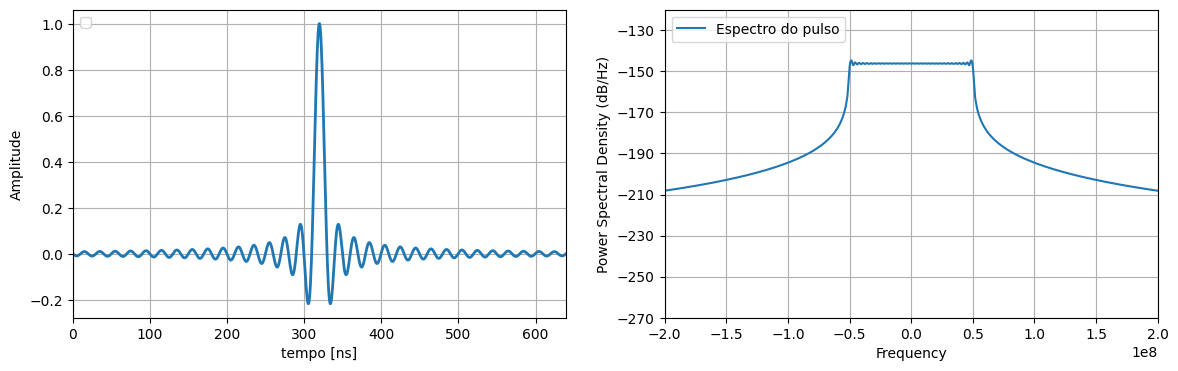

In [26]:
pulse = pulseShape(pulseType, SpS, N=1024, alpha=0.01)
pulse = np.array(pulse/max(abs(pulse)), dtype=np.complex64)

t = np.arange(pulse.size)*(Ta/1e-9)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2)
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-2*Rs, 2*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(pulse, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso')
axs[1].legend(loc='upper left');

## Formatação de Pulso

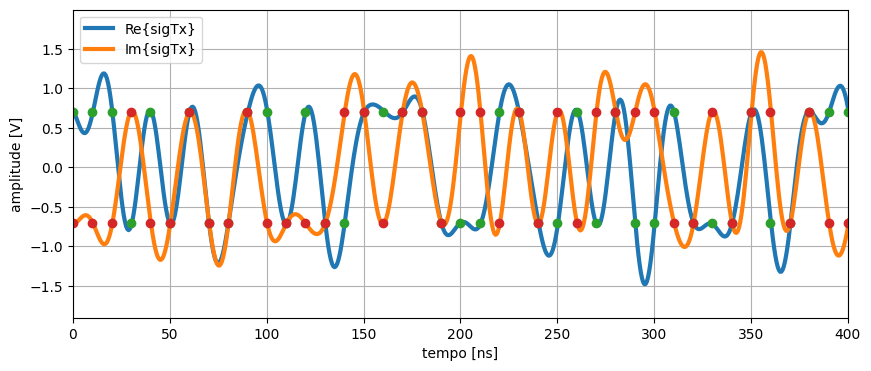

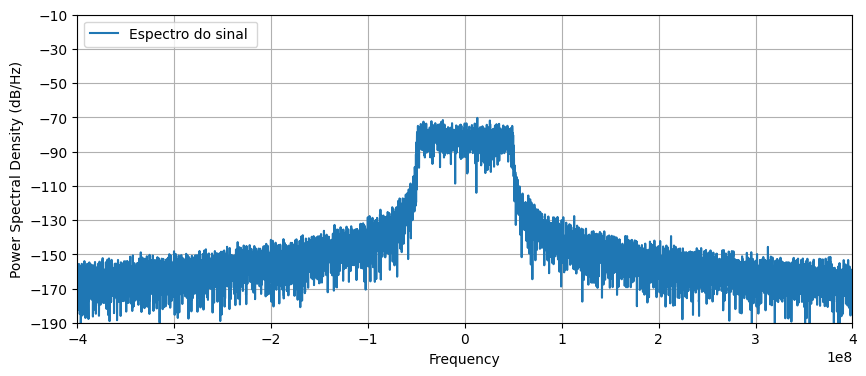

In [27]:
sigTx = dsp.firFilter(symbolsUp, pulse, symbolsUp.size, pulse.size)
sigTx = c2py(sigTx, symbolsUp.size)

t = np.arange(0, sigTx.size)*(Ta)/1e-9

# instantes centrais de sinalização.
symbolsUp[symbolsUp==0+1j*0] = np.nan + 1j*np.nan

plt.figure(figsize=(10, 4))

plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
plt.plot(t, sigTx.imag, '-', linewidth=3, label='Im{sigTx}')
plt.plot(t, symbolsUp.real, 'o') 
plt.plot(t, symbolsUp.imag, 'o') 
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-190, -10)
plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal ')
plt.legend(loc='upper left');

## Canal AWGN

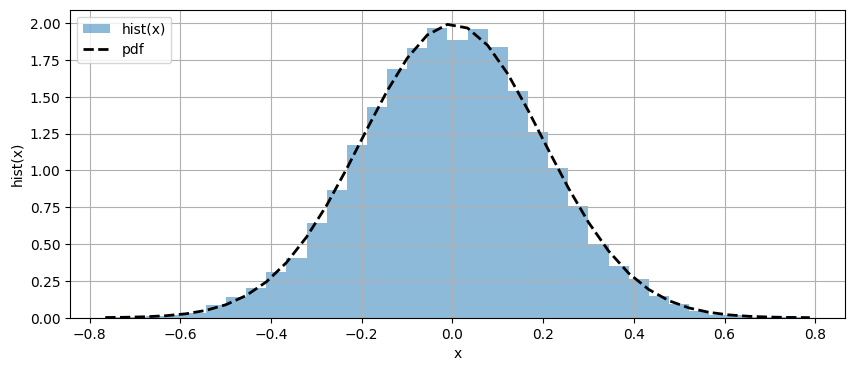

In [29]:
# ruído gaussiano branco
Nsamples = sigTx.size
σ2 = 0.0025              # variância
μ  = 0                  # média
σ  = np.sqrt(σ2*SpS)    # desvio padrão

noise = dsp.noise(Nsamples, μ, σ)
noise = c2py(noise, Nsamples)

plt.figure(None, figsize=(10, 4))
count, bins, ignored = plt.hist(noise, 35, density=True, label='hist(x)', alpha=0.5);
plt.plot(bins, 1/(σ * np.sqrt(2*np.pi)) * np.exp(-(bins - μ)**2 / (2 * σ**2)), '--', linewidth=2, label='pdf', color='black');
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('hist(x)')
plt.grid(True)

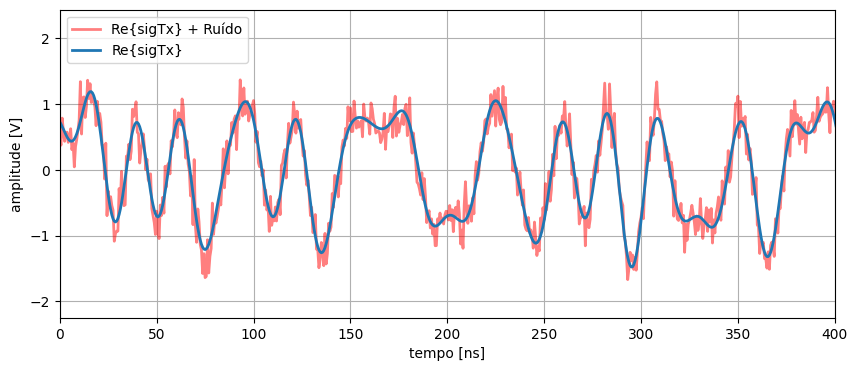

In [30]:
sigCh = np.array(sigTx + noise, dtype=np.complex64)
t = np.arange(0, sigTx.size)*(Ta)/1e-9

plt.figure(None, figsize=(10, 4))
plt.plot(t, sigCh.real, '-', linewidth=2, alpha=0.5, label='Re{sigTx} + Ruído', color='r')
plt.plot(t, sigTx.real, '-', linewidth=2, label='Re{sigTx}')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True);

## Filtro casado

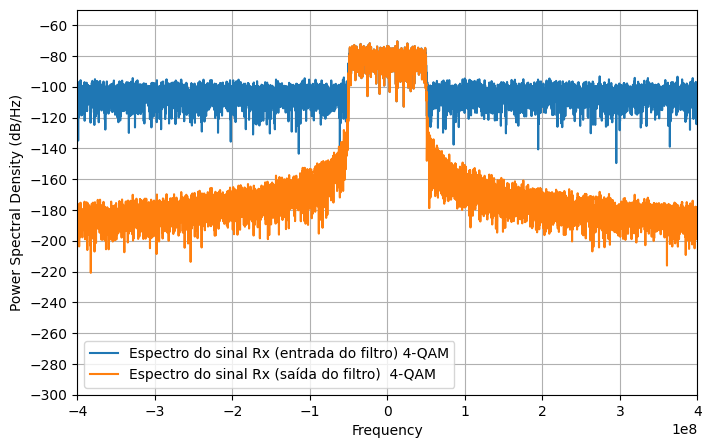

In [34]:
sigRx = dsp.matchedFilter(sigCh, pulse, sigCh.size, pulse.size)
sigRx = c2py(sigRx, sigCh.size)

# plot PSD
plt.figure(figsize=(8, 5));
plt.xlim(-4*Rs, 4*Rs);
plt.ylim(-300,-50);
plt.psd(sigCh, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-QAM')
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-QAM')
plt.legend(loc='lower left');

## Constelação 4-QAM

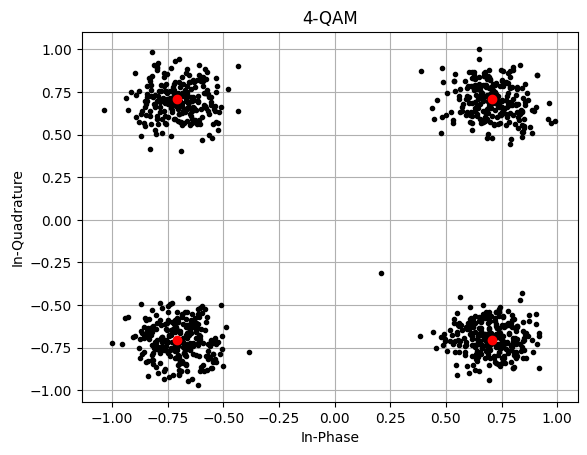

In [35]:
sigDecimate = dsp.downsample(sigRx, sigRx.size, SpS)
sigDecimate = c2py(sigDecimate, int(sigRx.size/SpS))

plt.plot(sigDecimate.real, sigDecimate.imag, '.', color='black')
plt.plot(constSymb.real, constSymb.imag, 'o', color='red')
plt.ylabel("In-Quadrature")
plt.xlabel("In-Phase")
plt.title("4-QAM")
plt.grid()

## Aplica a decisão ótima

In [36]:
# Decisão Ótima
decision_c = dsp.MLdetector(sigDecimate, constSymb, constSymb.size, sigDecimate.size)
decision_c = c2py(decision_c, sigDecimate.size)

ind = np.arange(100,decision_c.size-100)
SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')

SNRb = 23.00 dB


# Referências

[1] John G. Proakis. Digital Communications 5th-Ed